In [1]:
pwd

'/opt/tta/cmpark_AdaContrast'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
from sklearn.manifold import TSNE # sklearn 사용하면 easy !! 
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from pseudo_label import gmm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [4]:
### load data ####

## show shffle index image
from image_list import ImageList
from utils import get_augmentation
import cv2
val_transform = get_augmentation("five_crop")
val_dataset = ImageList(
        image_root='/mnt/data/VISDA-C/',
        label_file='/mnt/data/VISDA-C/validation_list.txt',
        transform=val_transform,
    )
test_tranform = get_augmentation('resize')

test_dataset = ImageList(
        image_root='/mnt/data/VISDA-C/',
        label_file='/mnt/data/VISDA-C/validation_list.txt',
        transform=get_augmentation("test"),
    )



In [5]:
all_image_path = [i[0] for i in val_dataset.item_list]

In [6]:
from glob import glob
image_list = glob('/mnt/data/VISDA-C/validation/a*/a*_*.jpg')

In [7]:
a = image_list[2]
for idx,i in enumerate(all_image_path): 
    if i == a: 
        print(idx)
        save_idx = idx
    

2973


In [8]:
o_image = test_dataset.__getitem__(save_idx)

images = val_dataset.__getitem__(save_idx)
aug_crop_images = torch.cat([test_tranform(i).unsqueeze(0) for i in images[0]])
aug_crop_images = torch.cat([o_image[0].unsqueeze(0),aug_crop_images])
print(o_image[1:])

(0, 2973)


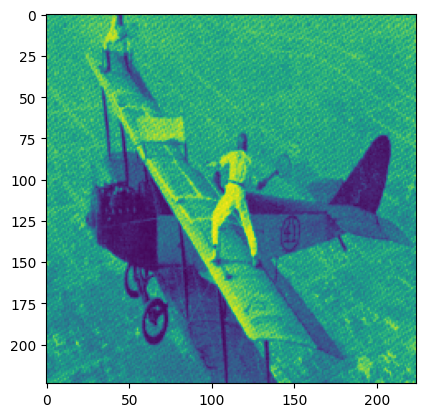

In [9]:
plt.imshow(o_image[0][0])

In [10]:
### load model ####
from classifier import Classifier
from moco.builder import AdaMoCo
from hydra import compose, initialize
from omegaconf import OmegaConf
try:
    initialize(config_path="configs", job_name="root")
except: 
    pass
over = []

args = compose(config_name="root",overrides=['+model_src.num_classes=12'])

args.data.data_root="/mnt/data/"
args.data.workers=8
args.data.dataset="VISDA-C"
args.data.source_domains="[train]"
args.data.target_domains="[validation]"
args.model_src.arch="resnet101"
args.model_tta.src_log_dir="/opt/tta/AdaContrast/checkpoint/VISDA-C/"
args.seed = 2020

# args = OmegaConf.to_yaml(cfg)
# args = OmegaConf.load("/opt/tta/cmpark_AdaContrast/configs/root.yaml")
use_pretrain = True
if use_pretrain: 
    checkpoint_path = '/opt/tta/cmpark_AdaContrast/debug/VISDA-C/target/checkpoint_0000_train-validation-None_2020.pth.tar'
else: 
    checkpoint_path = os.path.join(
            args.model_tta.src_log_dir,
            f"best_train_{args.seed}.pth.tar",
        )

src_model = Classifier(args, True, checkpoint_path)
momentum_model = Classifier(args, True, checkpoint_path)
model = AdaMoCo(
    src_model,
    momentum_model,
    K=args.model_tta.queue_size,
    m=args.model_tta.m,
    T_moco=args.model_tta.T_moco
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


sucees /opt/tta/cmpark_AdaContrast/debug/VISDA-C/target/checkpoint_0000_train-validation-None_2020.pth.tar
sucees /opt/tta/cmpark_AdaContrast/debug/VISDA-C/target/checkpoint_0000_train-validation-None_2020.pth.tar


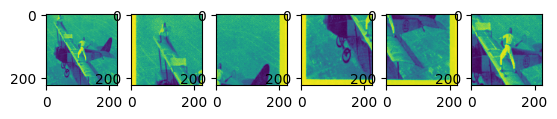

In [62]:
fig,axs = plt.subplots(1,len(aug_crop_images))
for i in range(len(aug_crop_images)):
    axs[i].imshow(aug_crop_images[i][0].cpu().numpy())

In [64]:
model = src_model.to('cuda')
aug_crop_images = aug_crop_images.to('cuda')
feats_w, logits_w = model(aug_crop_images, return_feats=True)

In [65]:
import torch.nn.functional as F
class_name = ['Aeroplane', 'Bicycle', 'Bus', 'Car', 
              'Horse', 'Knife', 'Motorcycle', 'Person', 
              'Plant', 'Skateboard', 'Train', 'Truck']
class_dict = {idx:i for idx, i in enumerate(class_name)}
s_logits_w = F.softmax(logits_w,dim=1)

In [66]:
print(o_image[1:])

(0, 2973)


In [67]:
print(s_logits_w)
[class_dict[i.item()] for i in s_logits_w.argmax(1)]

tensor([[0.0568, 0.1401, 0.0436, 0.1798, 0.0223, 0.0656, 0.0338, 0.0633, 0.1370,
         0.0296, 0.1101, 0.1182],
        [0.0552, 0.0389, 0.1072, 0.2804, 0.1236, 0.0192, 0.0738, 0.0380, 0.1086,
         0.0798, 0.0187, 0.0567],
        [0.0507, 0.0453, 0.0956, 0.0315, 0.0362, 0.0374, 0.0655, 0.1660, 0.2889,
         0.0871, 0.0255, 0.0704],
        [0.1585, 0.0760, 0.0358, 0.0437, 0.0702, 0.0585, 0.1739, 0.0725, 0.0286,
         0.0769, 0.1591, 0.0463],
        [0.0685, 0.1111, 0.0680, 0.0432, 0.0648, 0.0870, 0.0864, 0.0214, 0.0497,
         0.0672, 0.1781, 0.1546],
        [0.0523, 0.0589, 0.0753, 0.0313, 0.1406, 0.2784, 0.0488, 0.1217, 0.0163,
         0.1094, 0.0432, 0.0240]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


['Car', 'Car', 'Plant', 'Motorcycle', 'Train', 'Knife']